In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette("bright")

In [78]:
df = pd.read_csv('loan_data.csv')

In [79]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


### DATA CLEANING

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [81]:
df.isna().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [82]:
df.duplicated().sum()

0

## SPLITING IN X AND y

In [83]:
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [84]:
categorical_features = [col for col in X.columns if df[col].dtypes=='O']

In [85]:
numerical_features = [col for col in X.columns if df[col].dtypes!='O']

In [86]:
discrete_features = [col for col in numerical_features if len(df[col].unique())<=10]
len(discrete_features)

0

In [87]:
continuous_features = [col for col in numerical_features if len(df[col].unique())>=10]
len(continuous_features)

8

In [88]:
y.dtypes

dtype('int64')

### FEATURES TRANSFORMATION

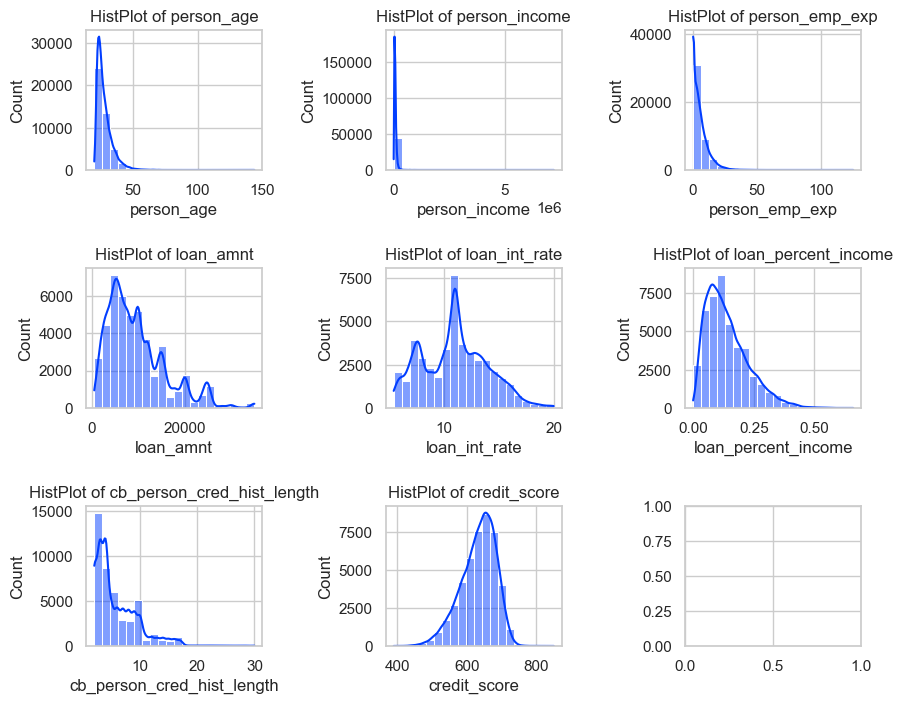

In [89]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8)) 

for ax, col in zip(axes.flat, numerical_features):
    sns.histplot(df[col],ax=ax,bins=20,kde=True)
    ax.set_title(f"HistPlot of {col}")
fig.subplots_adjust(wspace=0.7, hspace=0.7)

Here **person_age, person_income, person_emp_exp, cb_person_cred_hist_length** are skewed

In [90]:
df['person_age'].dtype

dtype('float64')

In [91]:
# Check Skewness
X[continuous_features].skew(axis=0, skipna=True)

person_age                     2.548154
person_income                 34.137583
person_emp_exp                 2.594917
loan_amnt                      1.179731
loan_int_rate                  0.213784
loan_percent_income            1.034512
cb_person_cred_hist_length     1.631720
credit_score                  -0.610261
dtype: float64

In [92]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method = "yeo-johnson")
transform_features = ["person_age", "person_income", "person_emp_exp", "cb_person_cred_hist_length"]
X_copy = pt.fit_transform(X[transform_features])

In [93]:
X_copy = pd.DataFrame(X_copy,columns=transform_features)

In [94]:
X_copy.skew(axis=0, skipna=True)

person_age                    0.139352
person_income                -0.017895
person_emp_exp               -0.021322
cb_person_cred_hist_length    0.073157
dtype: float64

### YES PowerTransformer can be applied

In [95]:
categorical_features

['person_gender',
 'person_education',
 'person_home_ownership',
 'loan_intent',
 'previous_loan_defaults_on_file']

In [96]:
len(numerical_features)

8

In [97]:
or_columns = ['person_gender','previous_loan_defaults_on_file']
oh_columns = ['person_education','person_home_ownership','loan_intent']
num_features = numerical_features

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
or_transformer = OrdinalEncoder()

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer([
    ('OneHotEncoder',oh_transformer,oh_columns),
    ('OrdinalEncoder',or_transformer,or_columns),
    ('Transformer',transform_pipe,transform_features),
    ('StandardScaler',numeric_transformer,num_features)
],remainder="passthrough")


In [98]:
X = preprocessor.fit_transform(X)

**Smoothing the data for balancing**

In [99]:
from imblearn.combine import SMOTEENN

smt = SMOTEENN(random_state=42,sampling_strategy='minority')
X_res, y_res = smt.fit_resample(X, y)

In [137]:
y_res.value_counts()

loan_status
1    33129
0    26600
Name: count, dtype: int64

## Train-Test Split

In [100]:
from sklearn.model_selection import train_test_split

In [101]:
X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)

In [105]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier

In [106]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [109]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [114]:
def evaluate_models(X,y,models):
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    model_list = []
    accuracy_list = []
    auc = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train,y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
        
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        
        print(list(models.keys())[i])
        model_list.append(list(models.keys())[i])
        
        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(model_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
        
    return report
        

In [115]:
base_model_report = evaluate_models(X_res,y_res,models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9814
- F1 score: 0.9835
- Precision: 0.9777
- Recall: 0.9894
- Roc Auc Score: 0.9803


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9607
- F1 score: 0.9649
- Precision: 0.9641
- Recall: 0.9656
- Roc Auc Score: 0.9600


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9599
- F1 score: 0.9642
- Precision: 0.9536
- Recall: 0.9751
- Roc Auc Score: 0.9581
----------------------------------
Model performance for Test set
- Accuracy: 0.9597
- F1 score: 0.9644
- Precision: 0.9551
- Recall: 0.9738
- Roc Auc Score: 0.9578


Logistic Regression
Model performance for Training 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier
Model performance for Training set
- Accuracy: 0.9547
- F1 score: 0.9594
- Precision: 0.9523
- Recall: 0.9665
- Roc Auc Score: 0.9533
----------------------------------
Model performance for Test set
- Accuracy: 0.9538
- F1 score: 0.9588
- Precision: 0.9554
- Recall: 0.9623
- Roc Auc Score: 0.9527




In [116]:
base_model_report

,Model Name,Accuracy
0,Random Forest,0.981416
4,K-Neighbors Classifier,0.979742
5,XGBClassifier,0.977733
6,Support Vector Classifier,0.961242
1,Decision Tree,0.960656
2,Gradient Boosting,0.959735
7,AdaBoost Classifier,0.953792
3,Logistic Regression,0.945505


### Here we can use Random Forest for Hyper Parameter Tuning

### Define the parameter distribution for Random forest

In [124]:
xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

rf_params = {
    "max_depth": [10, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [50, 100, 200]
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 5, 7, 9],
}

In [125]:
randomcv_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("KNN", KNeighborsClassifier(), knn_params)
]

In [127]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2, 
                                   n_jobs=-1)
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ....................max_depth=3, min_child_weight=1; total time=   1.0s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   1.0s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   1.0s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   1.0s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   1.0s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   1.1s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   1.0s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   1.0s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   1.0s
[CV] END ....................max_depth=5, min_child_weight=3; total time=   1.4s
[CV] END ....................max_depth=5, min_child_weight=1; total time=   1.5s
[CV] END ....................max_depth=5, min_child_weight=1; total time=   1.5s
[CV] END ...................

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=   4.6s
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=   4.8s
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=   5.6s
[CV] END ...max_depth=10, max_features=log2, n_estimators=50; total time=   4.6s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   9.5s
[CV] END ...max_depth=10, max_features=log2, n_estimators=50; total time=   4.1s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   9.7s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=  11.2s
[CV] END ...max_depth=10, max_features=log2, n_estimators=50; total time=   4.6s
[CV] END ..max_depth=10, max_features=log2, n_estimators=100; total time=   8.5s
[CV] END ..max_depth=10, max_features=log2, n_estimators=100; total time=   8.5s
[CV] END ..max_depth=10, max_features=log2, n_e

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ....algorithm=auto, n_neighbors=3, weights=distance; total time=   9.3s
[CV] END ....algorithm=auto, n_neighbors=3, weights=distance; total time=   9.3s
[CV] END ....algorithm=auto, n_neighbors=3, weights=distance; total time=   9.4s
[CV] END .....algorithm=auto, n_neighbors=3, weights=uniform; total time=   9.6s
[CV] END .....algorithm=auto, n_neighbors=3, weights=uniform; total time=   9.6s
[CV] END .....algorithm=auto, n_neighbors=5, weights=uniform; total time=   9.6s
[CV] END .....algorithm=auto, n_neighbors=3, weights=uniform; total time=   9.7s
[CV] END .....algorithm=auto, n_neighbors=5, weights=uniform; total time=   9.6s
[CV] END ....algorithm=auto, n_neighbors=5, weights=distance; total time=  12.5s
[CV] END ....algorithm=auto, n_neighbors=5, weights=distance; total time=  12.5s
[CV] END .....algorithm=auto, n_neighbors=7, weights=uniform; total time=  12.6s
[CV] END ....algorithm=auto, n_neighbors=7, weig

In [128]:
model_param

{'XGBoost': {'min_child_weight': 1, 'max_depth': 9},
 'RF': {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': None},
 'KNN': {'weights': 'distance', 'n_neighbors': 3, 'algorithm': 'auto'}}

In [129]:
from sklearn.metrics import roc_auc_score,roc_curve
best_models = {
    "Random Forest Classifier": RandomForestClassifier(**model_param['RF']),
    "KNeighborsClassifier": KNeighborsClassifier(**model_param['KNN']),
    "XGBClassifier": XGBClassifier(**model_param['XGBoost'],n_jobs=-1),
}
tuned_report =evaluate_models(X=X_res, y=y_res, models=best_models)

Random Forest Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9807
- F1 score: 0.9829
- Precision: 0.9764
- Recall: 0.9895
- Roc Auc Score: 0.9796


KNeighborsClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9874
- F1 score: 0.9888
- Precision: 0.9797
- Recall: 0.9981
- Roc Auc Score: 0.9859


XGBClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9810
- F1 score: 0.9830
- Precision: 0.9815
- Recall: 0.9846
- Roc Auc Score: 0.9805




In [130]:
tuned_report

,Model Name,Accuracy
1,KNeighborsClassifier,0.987360
2,XGBClassifier,0.980998
0,Random Forest Classifier,0.980747


In [131]:
best_model = KNeighborsClassifier(**model_param['KNN'])
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9874
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      5265
           1       0.98      1.00      0.99      6681

    accuracy                           0.99     11946
   macro avg       0.99      0.99      0.99     11946
weighted avg       0.99      0.99      0.99     11946



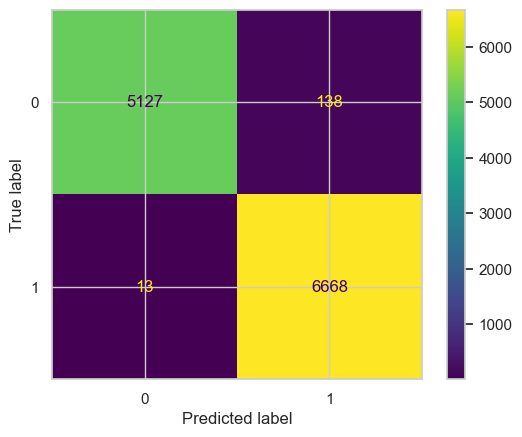

In [132]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)